In [1]:
import numpy as np
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import KFold, GroupKFold, StratifiedKFold
from sklearn.metrics import log_loss
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm
import gc
import matplotlib.pyplot as plt
import shap
import seaborn as sns

DIR_PATH = '/Users/sasanoshouta/Desktop/DIVE_INTO_CODE/kaggle/WDataFiles_Stage2'

# load JS visualization code to notebook
shap.initjs()

In [321]:
train = pd.read_csv(DIR_PATH+'/final_regular_result_W.csv')
test = pd.read_csv(DIR_PATH+'/stage1_test_W.csv')

y = train["result"]
s = train["Season"]
X = train.drop(['Season','TeamID1','TeamID2','result'], axis=1)
X_test = test.drop(['ID', 'Season','TeamID1','TeamID2'], axis=1)

参考ノートブック：https://www.kaggle.com/tnmasui/ncaam-2021-lgb-w-fe-on-three-datasets<br>
パラメータチューニング：https://qiita.com/R1ck29/items/50ba7fa5afa49e334a8f<br>

In [337]:
# 参考ノートブック：https://www.kaggle.com/tnmasui/ncaam-2021-lgb-w-fe-on-three-datasets
# パラメータチューニング：https://qiita.com/R1ck29/items/50ba7fa5afa49e334a8f
lgb_params = {'objective': 'regression',
              'metric': 'mae',
              'boosting': 'gbdt',
              'num_leaves': 16,
              'min_data_in_leaf': 600,
              'feature_fraction': 0.999,
              'bagging_fraction': 0.8,
              'bagging_freq': 5,
              'learning_rate': 0.02,
              'num_iterations' : 200,
              'max_depth':5
             }

def model_training(X, y, cv, groups, params, metric, early_stopping=10, \
    plt_iter=True, X_test=[], cat_features=[]):

    feature_importance = pd.DataFrame()
    val_scores=[]
    train_evals=[]
    valid_evals=[]

    if len(X_test) > 0:
        test_pred=np.zeros(len(X_test))

    for idx, (train_index, val_index) in enumerate(cv.split(X, y, groups)):

        print("###### fold %d ######" % (idx+1))
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]

        model = lgb.LGBMClassifier(**params)

        model.fit(X_train, y_train,
                  eval_set=[(X_train, y_train), (X_val, y_val)],
                  early_stopping_rounds=early_stopping,
                  verbose=20
                  #categorical_feature=list(cate_ft_lst),
                  )

        val_scores.append(model.best_score_['valid_1'][metric])
        train_evals.append(model.evals_result_['training'][metric])
        valid_evals.append(model.evals_result_['valid_1'][metric])
        

        if len(X_test) > 0:
            test_pred = test_pred + model.predict_proba(X_test)[:,1]

        fold_importance = pd.DataFrame()
        fold_importance["feature"] = X_train.columns
        fold_importance["importance"] = model.feature_importances_
        fold_importance["fold"] = idx+1
        feature_importance = pd.concat([feature_importance, fold_importance]
                                       , axis=0)
    
    
    if plt_iter:
        
        fig, axs = plt.subplots(3, 2, figsize=(9,12))
        
        for i, ax in enumerate(axs.flatten()):
            ax.plot(train_evals[i], label='training')
            ax.plot(valid_evals[i], label='validation')
            ax.set(xlabel='interations', ylabel=f'{metric}')
            ax.set_title(f'fold {i+1}', fontsize=12)
            ax.legend(loc='upper right', prop={'size': 9})
        fig.tight_layout()
        plt.show()
    
    print('### CV scores by fold ###')
    for i in range(cv.get_n_splits(X)):
        print(f'fold {i+1}: {val_scores[i]:.4f}')
    print('CV mean score: {0:.4f}, std: {1:.4f}.'\
          .format(np.mean(val_scores), np.std(val_scores)))
    
    feature_importance = feature_importance[["feature", "importance"]]\
                         .groupby("feature").mean().sort_values(
                         by="importance", ascending=False)
    feature_importance.reset_index(inplace=True)

    if len(X_test) > 0:
        test_pred = test_pred / cv.get_n_splits(X)
        return feature_importance, test_pred
    else:
        return feature_importance

###### fold 1 ######


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] feature_fraction is set=0.999, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.999
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
Training until validation scores don't improve for 100 rounds
[20]	training's l1: 0.429382	valid_1's l1: 0.432198
[40]	training's l1: 0.381748	valid_1's l1: 0.386554
[60]	training's l1: 0.349396	valid_1's l1: 0.356123
[80]	training's l1: 0.327258	valid_1's l1: 0.33555
[100]	training's l1: 0.312217	valid_1's l1: 0.32157
[120]	training's l1: 0.301645	valid_1's l1: 0.311866
[140]	training's l1: 0.29454	valid_1's l1

Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] feature_fraction is set=0.999, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.999
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
Training until validation scores don't improve for 100 rounds
[20]	training's l1: 0.429689	valid_1's l1: 0.42982
[40]	training's l1: 0.382335	valid_1's l1: 0.383155
[60]	training's l1: 0.350287	valid_1's l1: 0.35184
[80]	training's l1: 0.328329	valid_1's l1: 0.330755
[100]	training's l1: 0.313213	valid_1's l1: 0.316592
[120]	training's l1: 0.302848	valid_1's l1: 0.308025
[140]	training's l1: 0.295573	valid_1's l

Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] feature_fraction is set=0.999, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.999
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
Training until validation scores don't improve for 100 rounds
[20]	training's l1: 0.429333	valid_1's l1: 0.430952
[40]	training's l1: 0.381786	valid_1's l1: 0.384822
[60]	training's l1: 0.349603	valid_1's l1: 0.353691
[80]	training's l1: 0.327498	valid_1's l1: 0.332615
[100]	training's l1: 0.312413	valid_1's l1: 0.318966
[120]	training's l1: 0.30202	valid_1's l1: 0.309663
[140]	training's l1: 0.294877	valid_1's 

Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] feature_fraction is set=0.999, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.999
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
Training until validation scores don't improve for 100 rounds
[20]	training's l1: 0.429818	valid_1's l1: 0.429594
[40]	training's l1: 0.382551	valid_1's l1: 0.382262
[60]	training's l1: 0.35054	valid_1's l1: 0.350112
[80]	training's l1: 0.328881	valid_1's l1: 0.328372
[100]	training's l1: 0.314064	valid_1's l1: 0.313417
[120]	training's l1: 0.303926	valid_1's l1: 0.303524
[140]	training's l1: 0.29653	valid_1's l

Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] feature_fraction is set=0.999, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.999
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
Training until validation scores don't improve for 100 rounds
[20]	training's l1: 0.42967	valid_1's l1: 0.429809
[40]	training's l1: 0.382522	valid_1's l1: 0.382533
[60]	training's l1: 0.350593	valid_1's l1: 0.35061
[80]	training's l1: 0.328752	valid_1's l1: 0.329058
[100]	training's l1: 0.313756	valid_1's l1: 0.314423
[120]	training's l1: 0.303617	valid_1's l1: 0.304312
[140]	training's l1: 0.296358	valid_1's l

Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
[LightGBM] [Warning] feature_fraction is set=0.999, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.999
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
Training until validation scores don't improve for 100 rounds
[20]	training's l1: 0.43011	valid_1's l1: 0.430552
[40]	training's l1: 0.383055	valid_1's l1: 0.383754
[60]	training's l1: 0.351185	valid_1's l1: 0.352195
[80]	training's l1: 0.329594	valid_1's l1: 0.331113
[100]	training's l1: 0.314697	valid_1's l1: 0.316783
[120]	training's l1: 0.304447	valid_1's l1: 0.307277
[140]	training's l1: 0.297269	valid_1's 

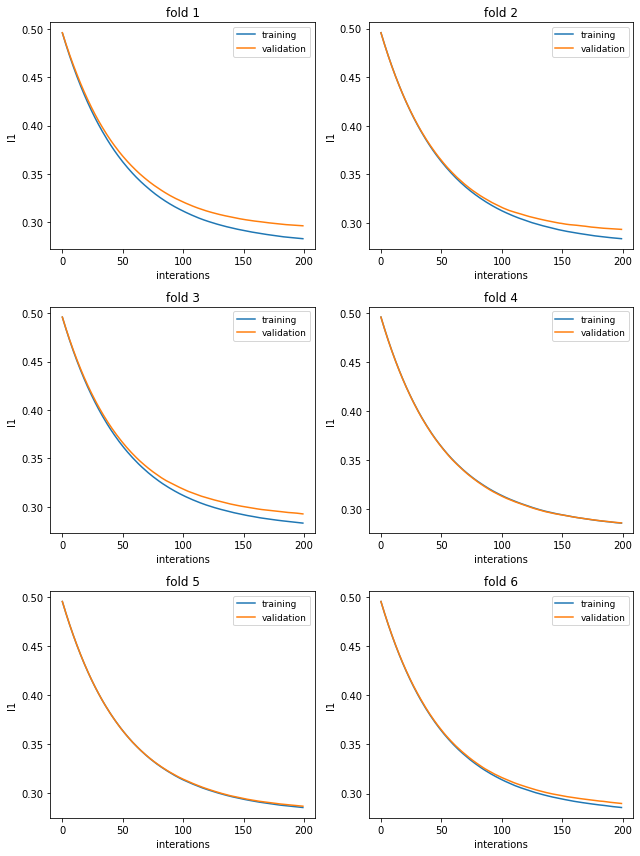

### CV scores by fold ###
fold 1: 0.2964
fold 2: 0.2935
fold 3: 0.2928
fold 4: 0.2855
fold 5: 0.2862
fold 6: 0.2898
CV mean score: 0.2907, std: 0.0039.
CPU times: user 3min 14s, sys: 8.32 s, total: 3min 22s
Wall time: 1min 21s


In [338]:
%%time
group_kfold = GroupKFold(n_splits=6)

feature_importance, test_pred = \
    model_training(X, y, group_kfold, s, lgb_params, 
    'l1', early_stopping=100, plt_iter=True, X_test=X_test)

Text(0.5, 1.0, 'Feature Importnace')

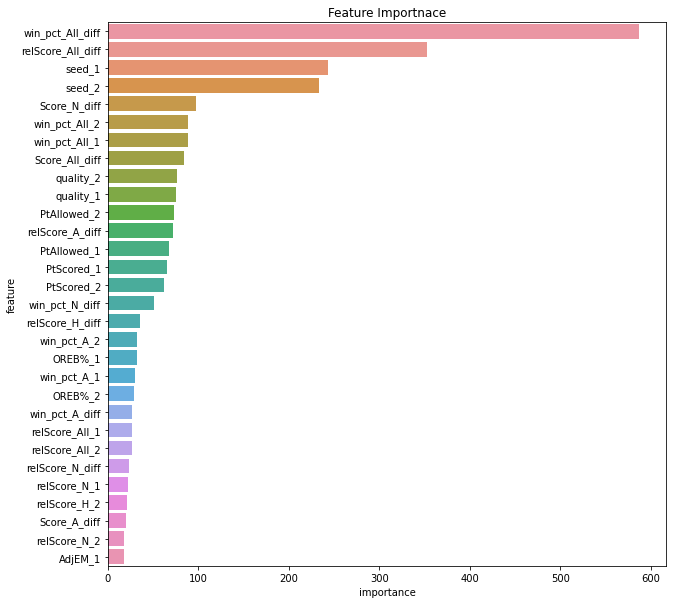

In [339]:
plt.figure(figsize=(10, 10));
sns.barplot(x="importance", y="feature", data=feature_importance[:30])
plt.title('Feature Importnace')

In [340]:
WSampleSubmission = pd.read_csv(DIR_PATH+'/WSampleSubmissionStage2.csv')

In [341]:
idx = test_pred.shape[0] // 2
test_pred[idx:] = 1 - test_pred[idx:]

pred = pd.concat([test.ID, pd.Series(test_pred)], axis=1).groupby('ID')[0]\
        .mean().reset_index().rename(columns={0:'Pred'})
sub = WSampleSubmission.drop(['Pred'],axis=1).merge(pred, on='ID')
sub.to_csv('submission_sasano_kouho3.csv', index=False)
sub.head()

,ID,Pred
0,2021_3104_3112,0.361944
1,2021_3104_3116,0.348486
2,2021_3104_3124,0.115569
3,2021_3104_3125,0.263386
4,2021_3104_3133,0.517688


<AxesSubplot:>

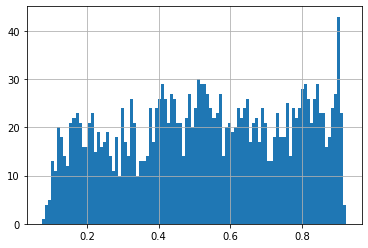

In [342]:
sub['Pred'].hist(bins=100)

In [343]:
print(len(sub.loc[sub['Pred'] > 0.5, 'Pred']))
print(len(sub.loc[sub['Pred'] <= 0.5, 'Pred']))
print(sub.Pred.min(), sub.Pred.max())

1117
899
0.07481867546123905 0.9245610581609509


<AxesSubplot:>

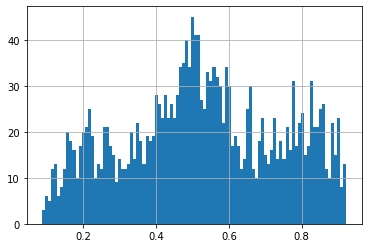

In [344]:
sub1 = pd.read_csv('submission_LGB_W.csv')
sub1['Pred'].hist(bins=100)

1120
896


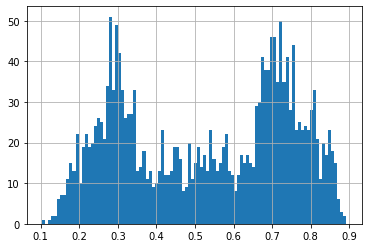

In [345]:
sub2 = pd.read_csv('submission_LGB_W2.csv')
sub2['Pred'].hist(bins=100)
print(len(sub2.loc[sub2['Pred'] > 0.5, 'Pred']))
print(len(sub2.loc[sub2['Pred'] <= 0.5, 'Pred']))

1087
929


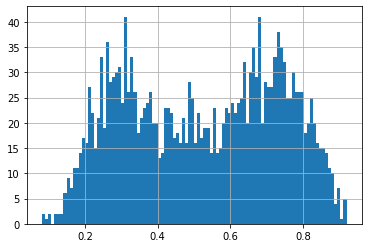

In [346]:
sub3 = pd.read_csv('submission_sasano_kouho1.csv')
sub3['Pred'].hist(bins=100)
print(len(sub3.loc[sub3['Pred'] > 0.5, 'Pred']))
print(len(sub3.loc[sub3['Pred'] <= 0.5, 'Pred']))